## Try different ways to reduce the dependence in the variance on k and z


In [2]:
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import cProfile
import emcee
import corner
import copy
# our own modules
import simplest_emulator
import linear_emulator
import gp_emulator
import data_PD2013
import mean_flux_model
import thermal_model
import pressure_model
import lya_theory
import likelihood
import emcee_sampler
import data_MPGADGET
import z_emulator
import p1d_arxiv

In [3]:
import matplotlib
font = {'size'   : 14}

matplotlib.rc('font', **font)

In [4]:
test_sim_num=50
skewers_label='Ns256_wM0.05'
#skewers_label=None
basedir="/p1d_emulator/sim_suites/emulator_256_28082019/"
#basedir="/p1d_emulator/sim_suites/Australia20/"
p1d_label=None
undersample_z=12
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
max_arxiv_size=None
kmax_Mpc=8
z_list=None

In [5]:
truth=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=4,pick_sim_number=test_sim_num,
                            drop_temp_rescalings=True,skewers_label=skewers_label)
## Set up k bins for emulator call
k_test=truth.data[1]["k_Mpc"][1:]
k_test=k_test[k_test<7]

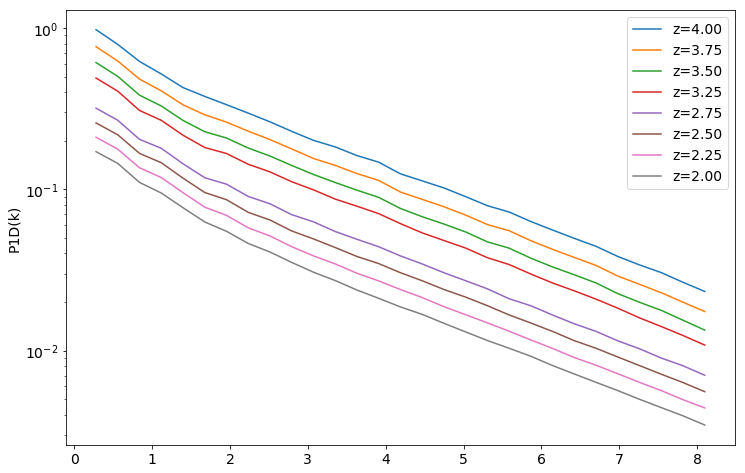

In [6]:
## What we were emulating before: P1D(k)
plt.figure(figsize=(12,8))
for item in truth.data:
    plt.plot(item["k_Mpc"][1:30],item["p1d_Mpc"][1:30],label="z=%.2f" % item["z"])
plt.yscale("log")
plt.legend()
plt.ylabel("P1D(k)")
plt.show()

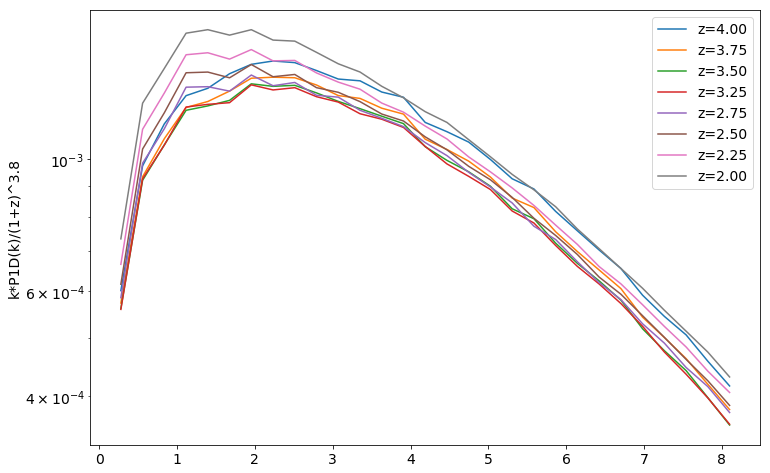

In [7]:
plt.figure(figsize=(12,8))
for item in truth.data:
    plt.plot(item["k_Mpc"][1:30],((1+item["z"])**-3.8)*item["k_Mpc"][1:30]*item["p1d_Mpc"][1:30],label="z=%.2f" % item["z"])
plt.yscale("log")
plt.legend()
plt.ylabel("k*P1D(k)/(1+z)^3.8")
plt.show()

In [8]:
arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=4,drop_sim_number=test_sim_num,
                            drop_temp_rescalings=True,skewers_label=skewers_label)


In [9]:
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=4,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin",passArxiv=arxiv,kmax_Mpc=8,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)

 /home/chris/.local/lib/python3.5/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 1592 points
Optimised


In [10]:
emu_red=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=4,
                                verbose=False,paramList=paramList,train=True,kmax_Mpc=8,
                                emu_type="k_bin",passArxiv=arxiv,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True,
                                reduce_var=True)

 /home/chris/.local/lib/python3.5/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 1592 points
Optimised


In [11]:
print(emu_red.training_k_bins)

[0.27925268 0.55850536 0.83775804 1.11701072 1.3962634  1.67551608
 1.95476876 2.23402144 2.51327412 2.7925268  3.07177948 3.35103216
 3.63028484 3.90953752 4.1887902  4.46804289 4.74729557 5.02654825
 5.30580093 5.58505361 5.86430629 6.14355897 6.42281165 6.70206433
 6.98131701 7.26056969 7.53982237]


4.0
[0.97266617 0.78845455 0.61855898 0.51879066 0.4276048  0.37712939
 0.33568583 0.29850851 0.26444812 0.23126564 0.20346343 0.18581172
 0.16455404 0.14993732 0.12717204 0.11527666 0.10447671 0.09237233
 0.08103751 0.07431196 0.06488635 0.0576613  0.05139622 0.04583624
 0.03958838]
3.75
[0.76500441 0.62346893 0.48284372 0.40935866 0.33555692 0.29140924
 0.26330323 0.23128676 0.20612998 0.18042468 0.15805716 0.14322026
 0.12745395 0.11590777 0.0983151  0.08854703 0.07997125 0.07111137
 0.06200073 0.05696024 0.04940769 0.04399995 0.03912697 0.03483851
 0.03000229]
3.5
[0.60878947 0.5001905  0.38330706 0.32906787 0.26820106 0.22880065
 0.20911087 0.18160067 0.16242525 0.14213246 0.12504517 0.11158955
 0.1001041  0.09061365 0.07744099 0.06894727 0.06217573 0.05550117
 0.04824528 0.0442478  0.03831478 0.03403257 0.03033029 0.026968
 0.02329066]
3.25
[0.49041711 0.40679916 0.30965044 0.2690877  0.21785481 0.1828322
 0.16806722 0.14427264 0.12944832 0.11282342 0.10044459 0.08814901
 0.07961

Text(0.5, 0, 'k 1/Mpc')

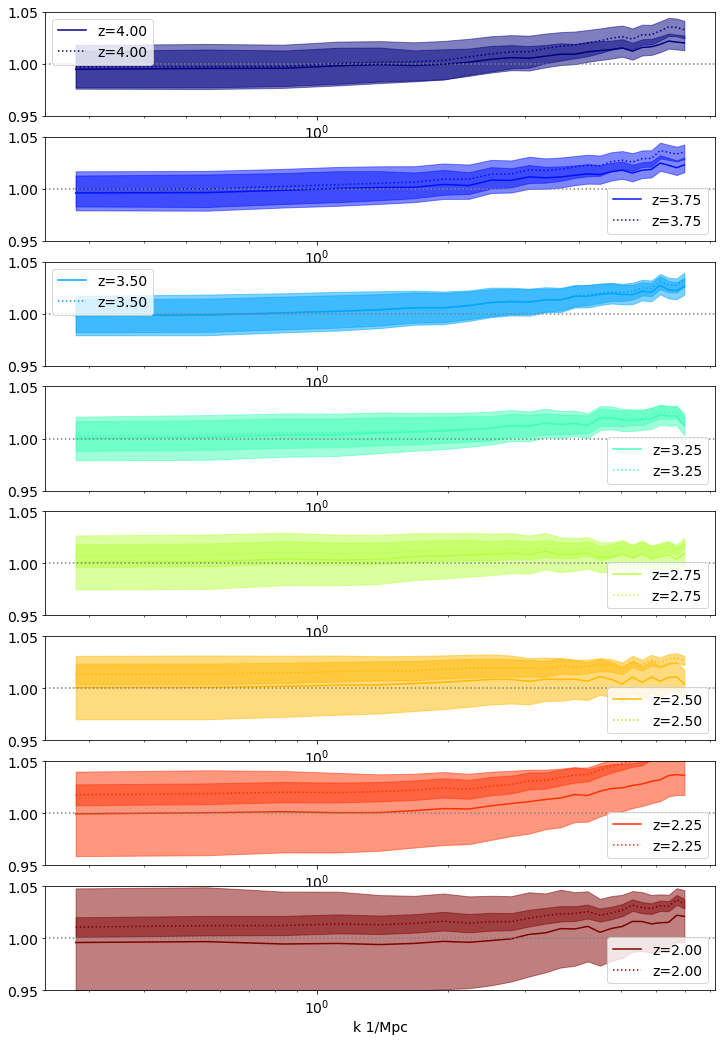

In [16]:
plt.figure(figsize=[12,18])
dex=0
for aa,item in enumerate(truth.data):
    print(item["z"])
    plt.subplot(len(truth.data),1,aa+1)
    col = plt.cm.jet(dex/(len(truth.data)-1))
    dex+=1
    emu_call={}
    for param in paramList:
        emu_call[param]=item[param]
    pred,err=emu.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    pred_tau,err_tau=emu_red.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    ## Plot z with different limits
    plt.plot(k_test,pred/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="solid",label="z=%.2f" % item["z"])
    plt.fill_between(k_test,(pred+np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)],
            (pred-np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)],alpha=0.5,color=col)
    #plt.plot(k_test,pred,color=col,label="z=%.2f" % item["z"])
    #plt.plot(k_test,pred_tau,color=col,linestyle="dotted",label="z=%.2f" % item["z"])
    #plt.plot(k_test,pred_tau/item["p1d_Mpc"][2:(len(k_test)+1)],color=col,linestyle="dotted",label="z=%.2f" % item["z"])
    plt.plot(k_test,pred_tau/item["p1d_Mpc"][1:(len(k_test))+1],color=col,linestyle="dotted",label="z=%.2f" % item["z"])
    plt.fill_between(k_test,(pred_tau+np.sqrt(np.diag(err_tau)))/item["p1d_Mpc"][1:(len(k_test))+1],
            (pred_tau-np.sqrt(np.diag(err_tau)))/item["p1d_Mpc"][1:(len(k_test))+1],alpha=0.5,color=col)
    plt.axhline(1,linestyle=":",color="gray")
    plt.xscale("log")
    plt.ylim(0.95,1.05)
    plt.legend()

#plt.xscale("log")
plt.xlabel("k 1/Mpc")
#plt.savefig("tau_scalings.pdf")

In [ ]:
emu.scalefactors

In [ ]:
emu_red.scalefactors

In [ ]:
mean=np.empty(len(emu_red.training_k_bins)-1)
std=np.empty(len(emu_red.training_k_bins)-1)
for aa in range(1,len(emu_red.training_k_bins)):
    mean[aa-1]=np.mean(emu_red.normspectra[:,aa])
    std[aa-1]=np.std(emu_red.normspectra[:,aa])

In [ ]:
plt.plot(std)

In [ ]:
emu_red.scalefactors